# Import Statements

In [3]:
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import (
    Conv2D, Conv2DTranspose, Dropout, Dense,
    Reshape, LayerNormalization, LeakyReLU
)
from keras import layers, models
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoProcessor, AutoModel, T5Tokenizer, T5ForConditionalGeneration
import cv2
from PIL import Image
from torchvision import transforms
import numpy as np
import pandas as pd
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, classification_report, f1_score,
    recall_score, precision_score, confusion_matrix
)

2025-12-07 08:54:10.672200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-07 08:54:10.672254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-07 08:54:10.673744: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-07 08:54:10.682262: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read Dataset

In [2]:
import os
import cv2
import numpy as np
import pathlib

class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape

    def returnimagesaslist(self):
        self.images = []
        for label in self.labels:
            label_dir = os.path.join(self.datasetpath, label)
            image_files = list(pathlib.Path(label_dir).glob('*.[jJpP][pPnNgG]*'))
            self.images.append(image_files)

    def readImages(self):
        self.returnimagesaslist()
        self.finalImages = []
        labels = []

        for label_index in range(len(self.labels)):
            for img_path in self.images[label_index]:
                img = cv2.imread(str(img_path))
                if img is None:
                    print(f"Skipping: {img_path}")
                    continue

                try:
                    img = cv2.resize(img, self.image_shape)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = img / 255.0  # Normalize
                except Exception as e:
                    print(f"Error in {img_path}: {e}")
                    continue

                self.finalImages.append(img)
                labels.append(label_index)

        images = np.array(self.finalImages)
        labels = np.array(labels)

        print(f"Loaded {len(images)} images.")
        return images, labels


# ACGAN Architecture

In [3]:
class ACGAN:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
        
    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain
        
    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis = 1)
        plt.figure(figsize = (12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap = 'gray')
            plt.title(ys[i])
        plt.show()
        
    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024, )(x)
        x = layers.Dense(8*8*filters[0],
                         kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides)(x)
        x = Conv2DTranspose(3, kernel_size = self.kernel_size, padding = padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs = [inputs, labels],
                                           outputs = x,
                                           name = 'generator')
        
    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides,
                      kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha = 0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1, )(x)
        labelsOutput = Dense(256,
                             kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2,)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs = inputs,
                                               outputs = [outputs, labelsOutput],
                                               name = 'discriminator')
        
    def build(self,):
        generatorInput = layers.Input(shape = (self.latent_space))
        discriminatorInput = layers.Input(shape = (self.image_shape))
        labelsInput = layers.Input(shape = (2, ))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss = ['mse', 'binary_crossentropy'],
                 optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta,
                                                        weight_decay = self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs = [generatorInput, labelsInput],
                           outputs = D(G([generatorInput, labelsInput])))
        GAN.compile(loss = ['mse', 'binary_crossentropy'],
                   optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta*0.5,
                                                          weight_decay = self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN
        
    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size = (self.batch_size, ))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape = (self.batch_size, ))
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size = (self.batch_size)),
                                                      num_classes = 2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose = 0))
            fakeTag = tf.zeros(shape = (self.batch_size, ))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 5000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag,
                                                                                                                dlossLabels,
                                                                                                                glossTag,
                                                                                                                glossLabels))
                self.samples(G, noize, fakeLabels)

In [4]:
ac_gan = ACGAN(eta = 0.0001, batch_size = 32, epochs = 32000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 3), kernel_size = 5)

In [5]:
generator, discriminator, GAN = ac_gan.build()

2025-12-04 15:08:43.361449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           2432      ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           51264     ['leaky_re_lu[0][0]']         
                                                                                      

In [7]:
generator_loaded = tf.keras.models.load_model('generator_final.h5')

2025-12-07 08:54:42.650194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10284 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:db:00.0, compute capability: 6.1


# VGG16 Architecture

In [7]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 3),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

In [8]:
model = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

# GRADCAM

## Load Trained VGG Classifier

In [18]:
m = tf.keras.models.load_model("vgg_model_fake.h5")

2025-12-04 15:43:15.746682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8594 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


## GradCAM

In [10]:
def load_and_preprocess_image(path):
    # Load image
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Could not load image: {path}")

    # Convert for display
    img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Show original image
    plt.figure(figsize=(5, 5))
    plt.imshow(img_display)
    plt.axis("off")
    plt.title("Original Image")
    plt.show()

    # Preprocess for model
    img = cv2.resize(img_display, (64, 64))  # model input size
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    return img

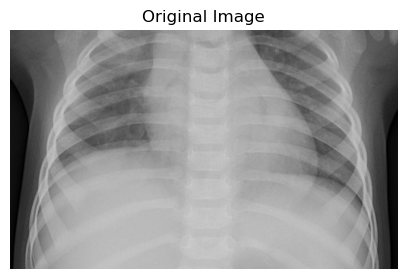

In [11]:
img_path = "chest_xray/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg"
# img_path = "chest_xray/chest_xray/train/PNEUMONIA/person1_bacteria_2.jpeg"
# img_path = "chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg"
img = load_and_preprocess_image(img_path)

In [12]:
last_conv_layer = m.get_layer("block5_conv3")

In [13]:
preds = m.predict(img)
pred_value = preds[0][0]   # sigmoid output

2025-12-04 15:08:49.435404: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


1/1 [==============================] - 2s 2s/step


In [14]:
grad_model = tf.keras.models.Model(
    inputs=m.inputs,
    outputs=[last_conv_layer.output, m.output]
)

In [15]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img)
    loss = predictions[:, 0]   # FIXED: only one output neuron

In [16]:
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

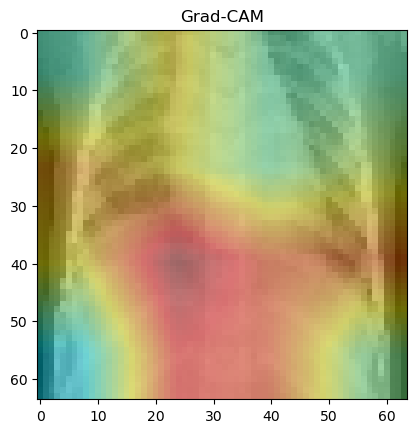

In [17]:
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (64, 64))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

img_uint8 = (img[0] * 255).astype(np.uint8)
superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap, 0.4, 0)

plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.show()
plt.show()


# BLIP

## Load Trained ACGAN

In [5]:
generator_loaded = tf.keras.models.load_model('generator_final.h5')

2025-12-04 15:10:48.314683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


## BLIP

In [4]:
def compute_cam(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img, (64, 64))
    img_norm = img_resized.astype("float32") / 255.0
    input_tensor = np.expand_dims(img_norm, axis=0)

    last_conv_layer = model.get_layer("block5_conv3")

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, pred = grad_model(input_tensor)
        loss = pred[:, 0]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_out, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    return heatmap


In [5]:
save_root = "generated"
os.makedirs(f"{save_root}/NORMAL", exist_ok=True)
os.makedirs(f"{save_root}/PNEUMONIA", exist_ok=True)

print("Folders ready.")

Folders ready.


In [8]:
def generate_and_save(G, count_per_class=5000, latent_dim=100):
    classes = {0: "NORMAL", 1: "PNEUMONIA"}
    
    for label in [0, 1]:

        print(f"Generating {count_per_class} images for class: {classes[label]}")

        noise = tf.random.uniform(shape=(count_per_class, latent_dim), minval=-1, maxval=1)

        labels = tf.keras.utils.to_categorical([label] * count_per_class, num_classes=2)

        generated = G.predict([noise, labels], verbose=1)

        for i, img in enumerate(generated):
            img = np.uint8(img * 255)  # convert back to 0–255
            bgr_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            filename = f"generated/{classes[label]}/{classes[label]}_{i}.jpg"
            cv2.imwrite(filename, bgr_img)

        print(f"Saved {count_per_class} {classes[label]} images.")

generate_and_save(generator_loaded, count_per_class=5000, latent_dim=100)


Generating 5000 images for class: NORMAL


2025-12-07 08:54:46.772753: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


157/157 [==============================] - 4s 20ms/step
Saved 5000 NORMAL images.
Generating 5000 images for class: PNEUMONIA
157/157 [==============================] - 3s 19ms/step
Saved 5000 PNEUMONIA images.


In [2]:
def get_pneumonia_images(root_dir):
    pneumonia_paths = []

    pneu_dir = os.path.join(root_dir, "PNEUMONIA")
    if os.path.isdir(pneu_dir):
        for fname in os.listdir(pneu_dir):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                pneumonia_paths.append(os.path.join(pneu_dir, fname))

    return pneumonia_paths

In [3]:
def cam_to_caption(cam):
    h, w = cam.shape
    mask = cam > 0.4

    if mask.sum() == 0:
        return "no strong activation detected"

    ys, xs = np.where(mask)
    cy, cx = ys.mean(), xs.mean()

    if cy < h/3: vert = "upper"
    elif cy > 2*h/3: vert = "lower"
    else: vert = "central"

    if cx < w/3: horiz = "left"
    elif cx > 2*w/3: horiz = "right"
    else: horiz = "middle"

    mx = cam.max()
    if mx > 0.75: intensity = "strong"
    elif mx > 0.50: intensity = "moderate"
    else: intensity = "weak"

    area = mask.sum() / (h*w)
    if area > 0.25: spread = "diffuse"
    elif area > 0.10: spread = "patchy"
    else: spread = "focal"

    return f"{intensity} {spread} activation in the {vert} {horiz} lung"


In [4]:
def generate_caption_for_file(model, img_path, save_path="caption.json"):

    cam = compute_cam(model, img_path)

    cap = cam_to_caption(cam)

    captions = {img_path: cap}
    with open(save_path, "w") as f:
        json.dump(captions, f, indent=4)

    print(f"[OK] {img_path} → {cap}")
    print("Saved:", save_path)

    return captions


In [7]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

clip_id = "openai/clip-vit-base-patch32"
clip_processor = AutoProcessor.from_pretrained(clip_id)
clip_model = AutoModel.from_pretrained(clip_id).to(device)
clip_model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [9]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5 = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [10]:
clip_dim = clip_model.config.projection_dim
t5_dim = t5.config.d_model                  

projector = nn.Sequential(
    nn.Linear(clip_dim, t5_dim),
    nn.Tanh()
).to(device)


In [11]:
class PneumoniaCaptionDataset(Dataset):
    def __init__(self, captions_json, clip_processor):
        with open(captions_json, "r") as f:
            self.data = json.load(f)
        self.paths = list(self.data.keys())
        self.caps  = list(self.data.values())
        self.clip_processor = clip_processor

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        caption = self.caps[idx]

        image = Image.open(path).convert("RGB")
        clip_inputs = self.clip_processor(images=image, return_tensors="pt")

        return path, clip_inputs, caption


In [12]:
def collate_fn(batch):
    paths = [x[0] for x in batch]
    pixel_values = torch.cat([b[1]["pixel_values"] for b in batch], dim=0)
    captions = [b[2] for b in batch]
    return paths, pixel_values, captions


In [13]:
def train_miniblip(dataset, epochs=5, lr=1e-4, batch_size=8, save_path="miniblip.pth"):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    optimizer = AdamW(
        list(projector.parameters()) + list(t5.parameters()),
        lr=lr
    )

    for epoch in range(1, epochs+1):
        pbar = tqdm(loader, desc=f"Epoch {epoch}")
        total_loss = 0

        for paths, pixel_values, captions in pbar:
            pixel_values = pixel_values.to(device)

            with torch.no_grad():
                clip_feat = clip_model.get_image_features(pixel_values)  # (B,512)

            proj_feat = projector(clip_feat)   
            proj_feat = proj_feat.unsqueeze(1)  

            tokenized = tokenizer(
                captions,
                padding=True,
                truncation=True,
                return_tensors="pt"
            ).to(device)

            labels = tokenized.input_ids.clone()
            labels[labels == tokenizer.pad_token_id] = -100

            encoder_outputs = t5.encoder(inputs_embeds=proj_feat)

            out = t5(
                encoder_outputs=encoder_outputs,
                labels=labels,
                return_dict=True
            )

            loss = out.loss
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=total_loss / (pbar.n + 1))

    torch.save({
        "projector": projector.state_dict(),
        "t5": t5.state_dict()
    }, save_path)

    print("Model saved to:", save_path)


In [14]:
captions_json = "generated/pneumonia_captions.json"
dataset = PneumoniaCaptionDataset(captions_json, clip_processor)

train_miniblip(dataset,
               epochs=6,
               lr=1e-4,
               batch_size=4,
               save_path="miniblip_model.pth")

Epoch 6: 100%|██████████| 1250/1250 [03:13<00:00,  6.45it/s, loss=0.000256]


Model saved to: miniblip_model.pth


In [15]:
def miniblip_generate(image_path):
    image = Image.open(image_path).convert("RGB")
    clip_inputs = clip_processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        feat = clip_model.get_image_features(**clip_inputs)
        proj = projector(feat).unsqueeze(1)
        enc = t5.encoder(inputs_embeds=proj)

        ids = t5.generate(
            encoder_outputs=enc,
            max_length=30,
            num_beams=3
        )

    return tokenizer.decode(ids[0], skip_special_tokens=True)


In [16]:
print(miniblip_generate("generated/PNEUMONIA/PNEUMONIA_0.jpg"))

strong diffuse activation in the central middle lung


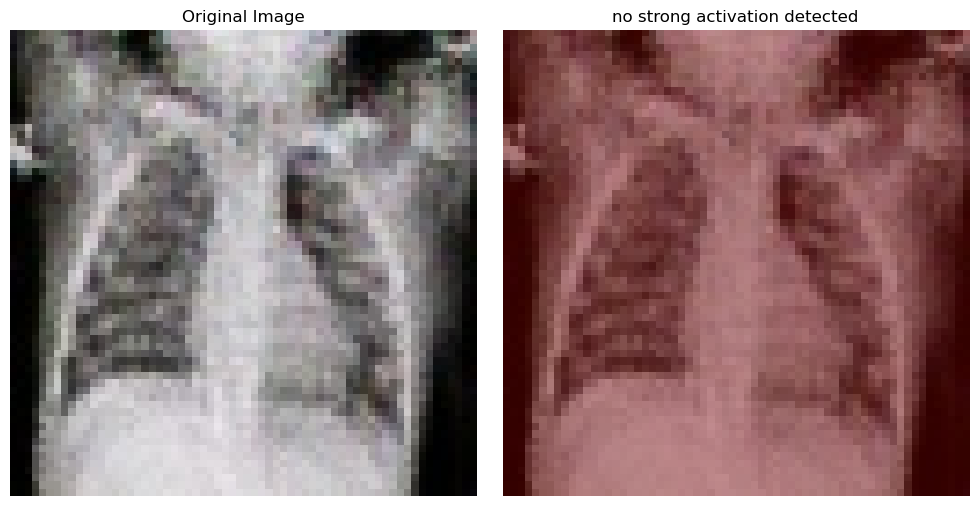

Explanation: no strong activation detected


In [21]:
def get_cam_tf(model, image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img, (64, 64)) / 255.0
    input_tensor = np.expand_dims(img_resized.astype("float32"), axis=0)

    last_conv_layer = model.get_layer("block5_conv3")

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(input_tensor)
        loss = preds[:, 0]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_output = conv_output[0]

    heatmap = tf.reduce_sum(pooled_grads * conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-8)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    return heatmap, img

def explain_image_tf(model, image_path):
    heatmap, img = get_cam_tf(model, image_path)

    caption = cam_to_caption(heatmap)

    heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img.astype(np.uint8), 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title(caption)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return caption

caption = explain_image_tf(
    m,
    "generated/NORMAL/NORMAL_0.jpg"
)
print("Explanation:", caption)


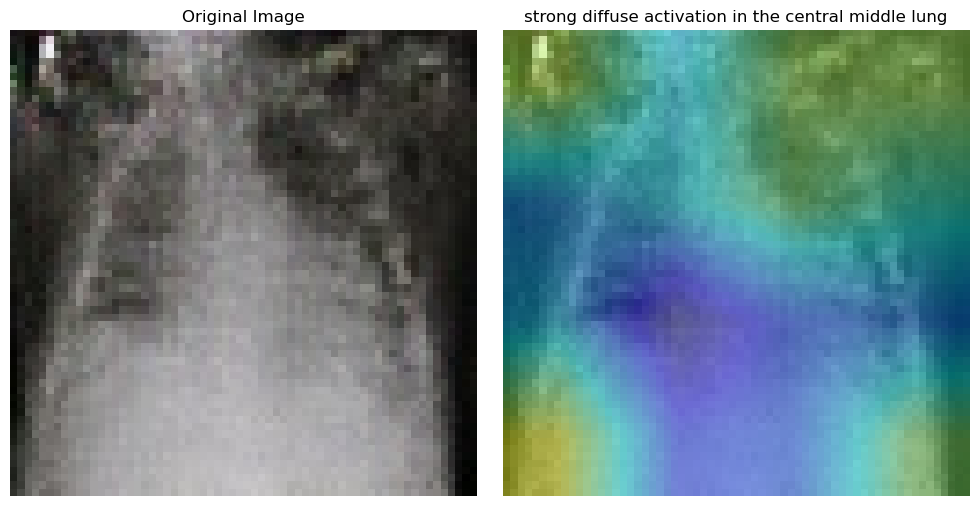

Explanation: strong diffuse activation in the central middle lung


In [22]:
def get_cam_tf(model, image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img, (64, 64)) / 255.0
    input_tensor = np.expand_dims(img_resized.astype("float32"), axis=0)

    last_conv_layer = model.get_layer("block5_conv3")

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(input_tensor)
        loss = preds[:, 0]  # pneumonia activation

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_output = conv_output[0]

    heatmap = tf.reduce_sum(pooled_grads * conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-8)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    return heatmap, img

def explain_image_tf(model, image_path):
    heatmap, img = get_cam_tf(model, image_path)

    caption = cam_to_caption(heatmap)

    heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img.astype(np.uint8), 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title(caption)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return caption

caption = explain_image_tf(
    m,
    "generated/PNEUMONIA/PNEUMONIA_0.jpg"
)
print("Explanation:", caption)
